In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tqdm import tqdm

import tensorflow as tf
import pandas  as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re
import pickle

tqdm.pandas()

In [6]:
df = pd.read_csv('../artifacts/09_06_2024_15_18_56/DataIngestionArtifacts/IMDB Dataset.csv')

In [4]:
class DatasetSplitter:
    def __init__(self, batch_size=64, train_split=0.9, seed=None, shuffle_buffer_size=None):
        """
        Initialize the DatasetSplitter with default or provided parameters.

        Args:
            batch_size (int, optional): The size of the batches. Default is 64.
            train_split (float, optional): The proportion of the dataset to use for training. Default is 0.9.
            shuffle_buffer_size (int, optional): The buffer size for shuffling the dataset. Default is None.
        """
        self.batch_size = batch_size
        self.train_split = train_split
        self.shuffle_buffer_size = shuffle_buffer_size
        self.seed = seed

    def split_and_prepare(self, dataset):
        """
        Split a dataset into training and validation sets, batch, and prefetch them.

        Args:
            dataset (tf.data.Dataset): The dataset to be split and prepared.

        Returns:
            tuple: A tuple containing the training and validation datasets, both batched and prefetched.
        """
        dataset_shuffled = self._shuffle_dataset(dataset)
        dataset_batched_and_prefetched = self._batch_and_prefetch(dataset_shuffled)

        train_size = int(self.train_split * len(dataset_batched_and_prefetched))
        train_dataset = dataset_batched_and_prefetched.take(train_size)
        valid_dataset = dataset_batched_and_prefetched.skip(train_size)

        self._display_info(dataset, train_dataset, valid_dataset)

        return train_dataset, valid_dataset

    def _shuffle_dataset(self, dataset):
        tf.random.set_seed(self.seed)
        if self.shuffle_buffer_size is None:
            self.shuffle_buffer_size = len(dataset)
        return dataset.shuffle(self.shuffle_buffer_size, seed=self.seed)

    def _batch_and_prefetch(self, dataset):
        return dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)

    def _display_info(self, dataset, train_dataset, valid_dataset):
        print(f"=================================== Original Dataset ===================================")
        print(f"Info data: {dataset}")
        print(f"Number of data: {len(dataset)}")
        print(f"BATCH SIZE: {self.batch_size}")

        print(f"=================================== Training Dataset ===================================")
        print(f"Info data: {train_dataset}")
        print(f"Training Split: {self.train_split}")
        print(f"Number of data: {len(train_dataset)}")

        print(f"=================================== Validation Dataset ===================================")
        print(f"Info data: {valid_dataset}")
        print(f"Validation Split: {round(1 - self.train_split, 2)}")
        print(f"Number of data: {len(valid_dataset)}")

In [5]:
def evaluate_model(model, test_dataset, class_names):
  """
  Evaluate the model using confusion matrix, classification report, and other metrics.

  Args:
  - model: Trained Keras model.
  - test_dataset: tf.data.Dataset for evaluation.
  - class_names: List of class names corresponding to the labels.
  """
  # Extract the true labels and predicted labels
  y_true = []
  y_pred = []

  for features, labels in test_dataset:
    predictions = model.predict(features, verbose=0)
    fix_label = np.squeeze(labels) * 1.0
    fix_pred = np.squeeze(np.round(predictions))

    y_pred.extend(fix_pred)
    y_true.extend(fix_label)

  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  # Compute confusion matrix
  cm = tf.math.confusion_matrix(y_true, y_pred).numpy()

  # Display confusion matrix with class names
  plt.figure(figsize=(12, 10))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

  # Print classification report with class names
  print("Classification Report:")
  print(classification_report(y_true, y_pred))

In [14]:
df['review'][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [7]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

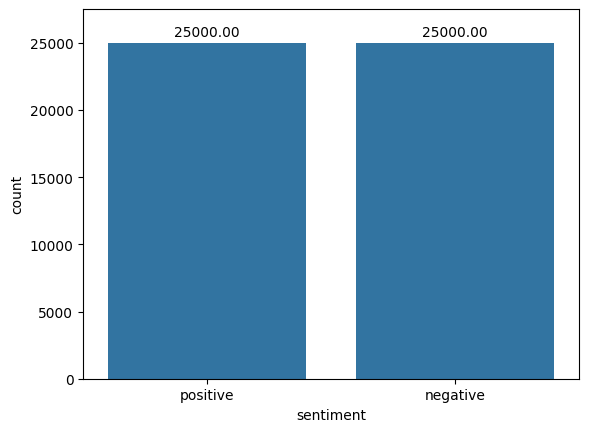

In [7]:
ax = sns.countplot(x='sentiment', data=df)
height_list = []
for bar in ax.patches:
    height = f'{bar.get_height():.2f}'
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_y() + bar.get_height() * 1.01
    ax.text(x, y, height, ha="center", va="bottom")
    height_list.append(height)
max_height = max(height_list)
ax.set_ylim(0, float(max_height) * 1.1)
plt.show()

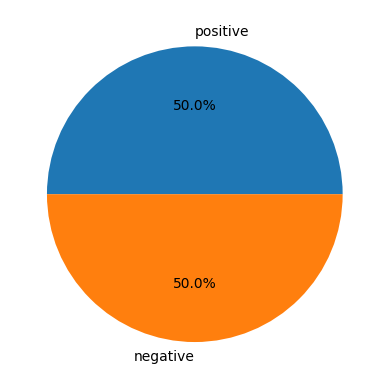

In [8]:
plt.pie(df['sentiment'].value_counts(), labels=df['sentiment'].value_counts().index, autopct='%1.1f%%')
plt.show()

In [9]:
df.loc[1, 'review']

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [28]:
def clean_review_func(review):
    # Menghapus tag HTML menggunakan regex
    review = re.sub(r'<.*?>', '', review.lower())

    # Menghapus URL/link
    review = re.sub(r'http\S+|www\S+|https\S+', '', review)

    # Mengganti semua kata dengan tanda hubung menjadi versi tanpa tanda hubung
    review = re.sub(r'(\w+)(-\w+)+', lambda x: x.group(0).replace('-', ' '), review)

    # Menghapus karakter khusus selain huruf, angka, dan spasi
    review = re.sub(r'[^a-zA-Z0-9\s]', '', review)

    # Menghapus spasi yang berlebihan
    review = re.sub(r'\s+', ' ', review).strip()

    return review

def label_processor(data):
    lb = LabelBinarizer()
    label_processor_obj = lb.fit(data)

    return label_processor_obj

In [29]:
# Contoh review IMDB dengan tag HTML dan karakter khusus
sample_review = df.loc[1, 'review']
cleaned_review = clean_review_func(sample_review)

display("Original Review:", sample_review)
print()
display("Cleaned Review:", cleaned_review)

'Original Review:'

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

'Cleaned Review:'

'a wonderful little production the filming technique is very unassuming very old time bbc fashion and gives a comforting and sometimes discomforting sense of realism to the entire piece the actors are extremely well chosen michael sheen not only has got all the polari but he has all the voices down pat too you can truly see the seamless editing guided by the references to williams diary entries not only is it well worth the watching but it is a terrificly written and performed piece a masterful production about one of the great masters of comedy and his life the realism really comes home with the little things the fantasy of the guard which rather than use the traditional dream techniques remains solid then disappears it plays on our knowledge and our senses particularly with the scenes concerning orton and halliwell and the sets particularly of their flat with halliwells murals decorating every surface are terribly well done'

In [30]:
df['review'] = df['review'].progress_apply(clean_review_func)

100%|██████████| 50000/50000 [01:00<00:00, 829.75it/s] 


In [31]:
df.loc[2, 'review']

'i thought this was a wonderful way to spend time on a too hot summer weekend sitting in the air conditioned theater and watching a light hearted comedy the plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer while some may be disappointed when they realize this is not match point 2 risk addiction i thought it was proof that woody allen is still fully in control of the style many of us have grown to lovethis was the most id laughed at one of woodys comedies in years dare i say a decade while ive never been impressed with scarlet johanson in this she managed to tone down her sexy image and jumped right into a average but spirited young womanthis may not be the crown jewel of his career but it was wittier than devil wears prada and more interesting than superman a great comedy to go see with friends'

In [32]:
label_processor_obj = label_processor(df['sentiment'])
label_processor_obj

LabelBinarizer()

In [33]:
df['sentiment'] = label_processor_obj.transform(df['sentiment'])

In [34]:
df[:4]

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0


In [35]:
print(f"sentiment encoded: {df.loc[:3, 'sentiment'].values}")
print(f"original sentiment: {label_processor_obj.inverse_transform(df.loc[:3, 'sentiment'])}")

sentiment encoded: [1 1 1 0]
original sentiment: ['positive' 'positive' 'positive' 'negative']


In [17]:
reviews = df['review']
sentiments = df['sentiment']

In [18]:
VOCAB_SIZE=10000
OOV_TOKEN="<UNK>"

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

In [19]:
decode_text_dicts = tokenizer.index_word

In [20]:
len(decode_text_dicts)

198024

In [21]:
for key, value in decode_text_dicts.items():
    if key < 10:
        print(f"{key} : {value}")
print('...')

1 : <UNK>
2 : the
3 : and
4 : a
5 : of
6 : to
7 : is
8 : in
9 : it
...


In [22]:
avg_len = round(sum([len(seq) for seq in sequences]) / len(sequences))
max_len = max([len(seq) for seq in sequences])
min_len = min([len(seq) for seq in sequences])

print(f"Average length: {avg_len}")
print(f"Max length: {max_len}")
print(f"Min length: {min_len}")

Average length: 228
Max length: 2464
Min length: 4


In [23]:
count_positive = 0
count_negative = 0

for row, (sequence, sentiment, review) in enumerate(zip(sequences, sentiments, reviews)):
  if (len(sequence) > 10) and (len(sequence) < 20):
  # if len(sequence) == 4:
    print(f'row index: {row} |', end=' ')
    print(f'sentiment: {lb.inverse_transform(np.array(sentiment))[0].upper()} |', end=' ')
    print(f'review: {review} | ', end=' ')
    # for index in sequence:
    #   print(f'{decode_text_dicts[index]}', end=' ')
    print()

    if sentiment == 1:
      count_positive += 1
    else:
      count_negative += 1

print()
print(f'count positive: {count_positive}')
print(f'count negative: {count_negative}')
print(f'number of reviews {count_positive + count_negative}')

row index: 413 | sentiment: NEGATIVE | review: a rating of 1 does not begin to express how dull depressing and relentlessly bad this movie is |  
row index: 1417 | sentiment: NEGATIVE | review: hated it with all my being worst movie ever mentally scarred help me it was that badtrust me |  
row index: 3709 | sentiment: NEGATIVE | review: long boring blasphemous never have i been so glad to see ending credits roll |  
row index: 13315 | sentiment: POSITIVE | review: this is a good film this is very funny yet after this film there were no good ernest films |  
row index: 18424 | sentiment: NEGATIVE | review: the characters are unlikeable and the script is awful its a waste of the talents of deneuve and auteuil |  
row index: 20274 | sentiment: NEGATIVE | review: youd better choose paul verhoevens even if you have watched it |  
row index: 24940 | sentiment: POSITIVE | review: i dont know why i like this movie so well but i never get tired of watching it |  
row index: 27680 | sentiment: P

In [24]:
imdb_reviews_tf_dataset = tf.data.Dataset.from_tensor_slices((reviews, sentiments))

In [25]:
print(f'info train data: {imdb_reviews_tf_dataset}')
print(f'number of train data: {len(imdb_reviews_tf_dataset)}')

info train data: <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
number of train data: 50000


In [26]:
sequence_and_word_list = []
for data, label in imdb_reviews_tf_dataset.shuffle(buffer_size=len(imdb_reviews_tf_dataset)).take(1):
    tf_data_label_str = label_processor_obj.inverse_transform(np.array(label))
    tf_data_text_lower = tf.strings.lower(data)
    tf_data_byte_to_text = tf.compat.as_text(tf_data_text_lower.numpy())
    tf_data_sequences = tokenizer.texts_to_sequences([tf_data_byte_to_text])

    print(f"{'FEATURE'.center(60, '=')}")
    display(f'DATA: {tf_data_byte_to_text}')
    print()
    display(f'COUNT VECTOR: {tf_data_sequences[0]}')
    print()
    print(f'DATA SHAPE: {data.shape}')
    print(f'DATA DTYPE: {data.dtype}')

    print()
    print(f"{'LABEL'.center(60, '=')}")
    print(f'LABEL: {label} --> {tf_data_label_str[0]}')
    print(f'LABEL SHAPE: {label.shape}')
    print(f'LABEL DTYPE: {label.dtype}')

    print()
    print('decode text: ', end=' ')
    for index in tf_data_sequences[0]:
        sequence_and_word_list.append(f'|{index}:{decode_text_dicts[index]}|')
    display(' '.join(sequence_and_word_list))

==========================FEATURE===========================


'DATA: rko had a reputation for making folksy homespun pieces of americanaanne shirley as dawn oday had been in films since she was a toddler by 1933 she was in limbo having played ann dvorak as a child in three on a match 1932 and a flower girl in both this side of heaven and the key both in 1934 george nicholls jnr remembered annes work from a previous film and thats how she got this part she also adopted anne shirley as her stage name the memorable stories are there lady of shallot in a leaky boat the stolen brooch the red hair incident anne was so right for the role of the chatty heartwarming orphan she was heartbreaking in her intensity her eagerness to please and also her fiery temper op heggie was wonderful as the understanding matthew cuthbert and helen westley was fine as the firm marilla tom brown was an excellent gilbert blythe gertrude messinger who had also been in films as a small child was fine as diana barry sara haden proved she could play someone other than aunt milli

'COUNT VECTOR: [8624, 67, 4, 2617, 16, 232, 1, 1, 1261, 5, 1, 4453, 14, 3242, 1, 67, 74, 8, 95, 235, 59, 13, 4, 1, 32, 6249, 59, 13, 8, 1, 260, 251, 2147, 1, 14, 4, 531, 8, 273, 20, 4, 1055, 8405, 3, 4, 6260, 247, 8, 193, 11, 482, 5, 2109, 3, 2, 1331, 193, 8, 7199, 748, 1, 1, 2002, 1, 158, 36, 4, 905, 19, 3, 177, 85, 59, 185, 11, 169, 59, 84, 5240, 1805, 4453, 14, 41, 914, 387, 2, 897, 569, 23, 48, 803, 5, 1, 8, 4, 1, 1763, 2, 2573, 1, 2, 813, 1105, 3305, 1805, 13, 38, 203, 16, 2, 215, 5, 2, 1, 5406, 8428, 59, 13, 5219, 8, 41, 3053, 41, 1, 6, 651, 3, 84, 41, 8864, 8806, 1, 1, 13, 391, 14, 2, 1741, 3742, 1, 3, 2732, 1, 13, 481, 14, 2, 5124, 1, 867, 1898, 13, 33, 317, 6481, 1, 1, 1, 35, 67, 84, 74, 8, 95, 14, 4, 390, 531, 13, 481, 14, 5168, 2806, 6192, 1, 2164, 59, 97, 286, 291, 80, 71, 3277, 1, 8, 2, 2136, 3171, 201, 13, 1854, 2806]'


DATA SHAPE: ()
DATA DTYPE: <dtype: 'string'>

===========================LABEL============================
LABEL: 1 --> positive
LABEL SHAPE: ()
LABEL DTYPE: <dtype: 'int64'>

decode text:  

'|8624:rko| |67:had| |4:a| |2617:reputation| |16:for| |232:making| |1:<UNK>| |1:<UNK>| |1261:pieces| |5:of| |1:<UNK>| |4453:shirley| |14:as| |3242:dawn| |1:<UNK>| |67:had| |74:been| |8:in| |95:films| |235:since| |59:she| |13:was| |4:a| |1:<UNK>| |32:by| |6249:1933| |59:she| |13:was| |8:in| |1:<UNK>| |260:having| |251:played| |2147:ann| |1:<UNK>| |14:as| |4:a| |531:child| |8:in| |273:three| |20:on| |4:a| |1055:match| |8405:1932| |3:and| |4:a| |6260:flower| |247:girl| |8:in| |193:both| |11:this| |482:side| |5:of| |2109:heaven| |3:and| |2:the| |1331:key| |193:both| |8:in| |7199:1934| |748:george| |1:<UNK>| |1:<UNK>| |2002:remembered| |1:<UNK>| |158:work| |36:from| |4:a| |905:previous| |19:film| |3:and| |177:thats| |85:how| |59:she| |185:got| |11:this| |169:part| |59:she| |84:also| |5240:adopted| |1805:anne| |4453:shirley| |14:as| |41:her| |914:stage| |387:name| |2:the| |897:memorable| |569:stories| |23:are| |48:there| |803:lady| |5:of| |1:<UNK>| |8:in| |4:a| |1:<UNK>| |1763:boat| |2:the| 

In [27]:
# Function to tokenize and pad sequences
def tokenize_and_pad(text, max_pad):
    text_lower = tf.strings.lower(text)  # Lowercase the text
    byte_to_text = tf.compat.as_text(text_lower.numpy())  # Ensure that the input is a string
    sequences = tokenizer.texts_to_sequences([byte_to_text])  # Convert text to sequence of tokens
    padded = pad_sequences(sequences, maxlen=max_pad, padding='post')  # Pad sequences to the same length
    return padded[0]

# Wrapper to use the function with `map`
def tf_tokenize_and_pad(text, label, max_pad):
    label = tf.cast(label, tf.int32)
    text_tokenized = tf.py_function(tokenize_and_pad, inp=[text, max_pad], Tout=(tf.int32))
    text_tokenized.set_shape((max_pad, ))
    return text_tokenized, label

In [28]:
imdb_reviews_tokenized = imdb_reviews_tf_dataset.map(
    map_func= lambda review, sentiment:
        tf_tokenize_and_pad(
            text=review,
            label=sentiment,
            max_pad=avg_len
        ),
    num_parallel_calls=tf.data.AUTOTUNE
)
imdb_reviews_tokenized_cached = imdb_reviews_tokenized.cache()

In [29]:
print(f'info train data: {imdb_reviews_tokenized_cached}')
print(f'number of train data: {len(imdb_reviews_tokenized_cached)}')

info train data: <CacheDataset element_spec=(TensorSpec(shape=(228,), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
number of train data: 50000


In [40]:
# Length of the vocabulary in chars
# The embedding dimension
EMBEDDING_DIM = 64
# Number of RNN units
RNN_UNITS = 64
# batch size
BATCH_SIZE = 64
# Model Path
MODEL_PATH = "../model/imdb_sentiment_review_lstm_revision.keras"

In [75]:
splitter = DatasetSplitter(batch_size=BATCH_SIZE, train_split=0.8, seed=42)

In [76]:
imdb_reciews_tf_data_train, imdb_reciews_tf_data_valid = splitter.split_and_prepare(imdb_reviews_tokenized_cached)

=================================== Original Dataset ===================================
Info data: <CacheDataset element_spec=(TensorSpec(shape=(228,), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
Number of data: 50000
BATCH SIZE: 64
=================================== Training Dataset ===================================
Info data: <_TakeDataset element_spec=(TensorSpec(shape=(None, 228), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Training Split: 0.8
Number of data: 625
=================================== Validation Dataset ===================================
Info data: <_SkipDataset element_spec=(TensorSpec(shape=(None, 228), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Validation Split: 0.2
Number of data: 157


In [78]:
def build_model_lstm(vocab_size, embedding_dim):
    # Input layer
    inputs = tf.keras.Input(shape=(None,), dtype=tf.int32, name='inputs')

    # Embedding layer
    x = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True, name='embedding')(inputs)

    # LSTM layer
    x = tf.keras.layers.LSTM(64, name='lstm')(x)

    # Dense layer with sigmoid activation
    outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='lstm_model')

    return model

  # def build_model_bilstm(vocab_size, embedding_dim):
  #   # Input layer
  #   inputs = tf.keras.Input(shape=(None,), dtype=tf.int32, name='inputs')

  #   # Embedding layer
  #   x = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True, name='embedding')(inputs)

  #   # Bidirectional LSTM layers
  #   x = tf.keras.layers.Bidirectional(
  #       tf.keras.layers.LSTM(64), name='bilstm_1'
  #   )(x)

  #   # Dense layer with sigmoid activation
  #   outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(x)

  #   # Create the model
  #   model = tf.keras.Model(inputs=inputs, outputs=outputs, name='lstm_model')

  #   return model

In [79]:
model = build_model_lstm(
  vocab_size = VOCAB_SIZE,
  embedding_dim = EMBEDDING_DIM,
)

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy', 'Precision', 'Recall'])

model.summary()

Model: "lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)       │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 64)       │        640,000 │ inputs[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, None)           │              0 │ inputs[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 64)             │         33,024 │ embedding[0][0],       │
│                           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             65 │ lstm[0][0]             │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 673,089 (2.57 MB)

 Trainable params: 673,089 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath=MODEL_PATH,  # Path untuk menyimpan model
  monitor='val_loss',  # Metrik yang dipantau
  save_best_only=True,  # Hanya menyimpan model terbaik
  save_weights_only=False,  # Menyimpan seluruh model (bukan hanya bobotnya)
  mode='min',  # Mode untuk memantau metrik (min untuk loss)
  verbose=1,
)

plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_loss',  # Metrik yang akan dipantau
  factor=0.5,  # Faktor pengurangan learning rate. new_lr = lr * factor
  patience=20,  # Jumlah epoch tanpa perbaikan setelah learning rate akan dikurangi
  verbose=1,  # Output
  mode='auto',  # Mode otomatis menurunkan learning rate baik ketika metrik berhenti meningkat atau menurun
  min_delta=0.001,  # Perubahan minimum dalam metrik yang dianggap sebagai peningkatan
  cooldown=0,  # Jumlah epoch untuk menunggu sebelum melanjutkan operasi normsal setelah learning rate dikurangi.
  min_lr=0  # Batas bawah learning rate
)

early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss',
  patience=25,
  restore_best_weights=True,
  verbose=1
)


history = model.fit(
    imdb_reciews_tf_data_train,
    validation_data=imdb_reciews_tf_data_valid,
    epochs=20,
    callbacks=[
      plateau_callback,
      early_stopping,
      checkpoint_callback
    ]
)

Epoch 1/20
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - Precision: 0.7430 - Recall: 0.8172 - accuracy: 0.7583 - loss: 0.4741
Epoch 1: val_loss improved from inf to 0.24161, saving model to /content/drive/MyDrive/Colab Notebooks/Tensorflow Documentation/Assets/Model/imdb_sentiment_review_lstm_revision.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - Precision: 0.7435 - Recall: 0.8173 - accuracy: 0.7587 - loss: 0.4735 - val_Precision: 0.9228 - val_Recall: 0.8942 - val_accuracy: 0.9104 - val_loss: 0.2416 - learning_rate: 0.0010
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - Precision: 0.8990 - Recall: 0.9009 - accuracy: 0.9002 - loss: 0.2539
Epoch 2: val_loss improved from 0.24161 to 0.20314, saving model to /content/drive/MyDrive/Colab Notebooks/Tensorflow Documentation/Assets/Model/imdb_sentiment_review_lstm_revision.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - Precision: 0.8990 - Recall: 0.9009 - accuracy: 0.9002 - loss: 0.2539 - val_Precision: 0.8881 - val_Recall: 0.958

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Tensorflow Documentation/Assets/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/Colab Notebooks/Tensorflow Documentation/Assets/label_binerizer.pickle', 'wb') as handle:
    pickle.dump(label_processor_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [81]:
# Evaluate the model
evaluation_results = model.evaluate(imdb_reciews_tf_data_valid)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - Precision: 0.9976 - Recall: 0.9953 - accuracy: 0.9965 - loss: 0.0097


In [37]:
print(f'''
Evaluation results:
  Loss: {evaluation_results[0]}
  Precision: {evaluation_results[1]}
  Recall: {evaluation_results[2]}
  Accuracy: {evaluation_results[3]}
''')


Evaluation results:
  Loss: 0.055452264845371246
  Precision: 0.9836999773979187
  Recall: 0.9926605224609375
  Accuracy: 0.9745796918869019



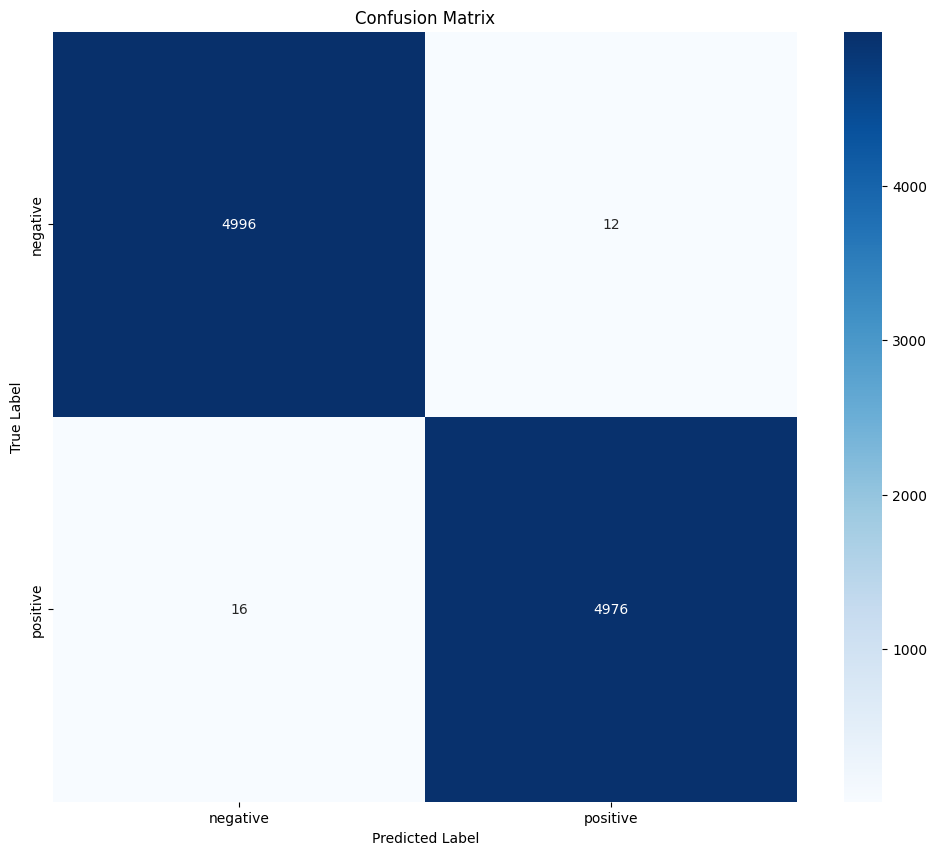

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5008
         1.0       1.00      1.00      1.00      4992

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



In [83]:
evaluate_model(model, imdb_reciews_tf_data_valid, lb.classes_)

In [116]:
def clean_review_func(review):
    # Menghapus tag HTML menggunakan regex
    review = re.sub(r'<.*?>', '', review.lower())

    # Menghapus URL/link
    review = re.sub(r'http\S+|www\S+|https\S+', '', review)

    # Mengganti semua kata dengan tanda hubung menjadi versi tanpa tanda hubung
    review = re.sub(r'(\w+)(-\w+)+', lambda x: x.group(0).replace('-', ' '), review)

    # Menghapus karakter khusus selain huruf, angka, dan spasi
    review = re.sub(r'[^a-zA-Z0-9\s]', '', review)

    # Menghapus spasi yang berlebihan
    review = re.sub(r'\s+', ' ', review).strip()

    return review

In [117]:
model_loaded = tf.keras.models.load_model(MODEL_PATH)

with open('/content/drive/MyDrive/Colab Notebooks/Tensorflow Documentation/Assets/tokenizer.pickle', 'rb') as handle:
    tokenizer_loaded = pickle.load(handle)

with open('/content/drive/MyDrive/Colab Notebooks/Tensorflow Documentation/Assets/label_binerizer.pickle', 'rb') as handle:
    label_processor_obj_loaded = pickle.load(handle)

In [130]:
# Example text reviews
test_reviews = [
  "I just watched this film and I am thoroughly impressed! The story is incredibly inspiring and filled with heartwarming moments. The acting is outstanding, especially the lead actors who brought their characters to life so well. The cinematography is beautiful, with stunning shots and effective use of color to convey emotions. The background music is also perfectly chosen, adding depth to each scene. I feel that this film successfully delivers a powerful message about courage and perseverance. This is one of those films that I will watch repeatedly, and I highly recommend it to anyone looking for a meaningful and entertaining movie.",

  "I was very disappointed with this film. The story felt very cliché and there was nothing new or interesting. The acting was unconvincing, with dialogue that sounded stiff and unnatural. The cinematography was average, nothing special or innovative. The background music did not help either, and was actually distracting in some scenes. I feel that the film failed to deliver the message it intended and ended up being boring. Many scenes felt too long and unnecessary, making the film drag. Overall, I do not recommend this film and feel that my time was wasted watching it.",

  "It was actually a good movie, but I don't think I would recommend my child to watch this movie. because the scenes are full of blood.",

  "I don't like this is movie!!!!!!!!!",

  "I don't think this is a good movie"
]

In [131]:
# Preprocess the text reviews
def preprocess_review(review, max_pad=235):
    sequences = tokenizer_loaded.texts_to_sequences([review])
    padded_sequences = pad_sequences(sequences, maxlen=max_pad, padding='post')
    return padded_sequences

In [132]:
# Predict sentiment for each review
for review in test_reviews:
  cleaned_review = clean_review_func(review)
  processed_review = preprocess_review(review, max_pad=avg_len)
  prediction = np.round(model_loaded.predict(processed_review, verbose=0)).squeeze()
  sentiment = label_processor_obj_loaded.classes_[int(prediction)]
  display(f"Review: {review}")
  display(f"Predicted Sentiment: {sentiment.upper()}")
  print()

'Review: I just watched this film and I am thoroughly impressed! The story is incredibly inspiring and filled with heartwarming moments. The acting is outstanding, especially the lead actors who brought their characters to life so well. The cinematography is beautiful, with stunning shots and effective use of color to convey emotions. The background music is also perfectly chosen, adding depth to each scene. I feel that this film successfully delivers a powerful message about courage and perseverance. This is one of those films that I will watch repeatedly, and I highly recommend it to anyone looking for a meaningful and entertaining movie.'

'Predicted Sentiment: POSITIVE'

'Review: I was very disappointed with this film. The story felt very cliché and there was nothing new or interesting. The acting was unconvincing, with dialogue that sounded stiff and unnatural. The cinematography was average, nothing special or innovative. The background music did not help either, and was actually distracting in some scenes. I feel that the film failed to deliver the message it intended and ended up being boring. Many scenes felt too long and unnecessary, making the film drag. Overall, I do not recommend this film and feel that my time was wasted watching it.'

'Predicted Sentiment: NEGATIVE'

"Review: It was actually a good movie, but I don't think I would recommend my child to watch this movie. because the scenes are full of blood."

'Predicted Sentiment: POSITIVE'

"Review: I don't like this is movie!!!!!!!!!"

'Predicted Sentiment: NEGATIVE'

"Review: I don't think this is a good movie"

'Predicted Sentiment: POSITIVE'